In [1]:
import os, sys
sys.path.append(os.path.dirname(os.getcwd()) + '/source')

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from model import ode_y, ode_y_jump_approach_one
from numba import njit

**ODE for y on (0, 2)**:
\begin{align*}
0 = \max_{\tilde{e}} \min_h &  -\delta \phi(y) + \delta \eta \log \tilde{e} \\
&+ \frac{d\phi(y)}{dy}\tilde{e}(\sum_{i=1}^n \pi_i^c \theta_i\ + \sigma_y \cdot h) + \frac{1}{2} \frac{d^2 \phi(y)}{(d y)^2}|\sigma_y|^2(\tilde{e})^2\\
&+ (\eta-1)(\gamma_1 + \gamma_2 y)\tilde{e}(\sum_{i=1}^n \pi_i^c \theta_i\ + \sigma_y \cdot h)\\
& +\frac{\xi_{1,m}}{2}h^\prime h + \xi_a\sum_{i=1}^{n} \pi_i^c(\log \pi_i^c - \log \hat{\pi}_i^c)\\
& + \mathcal{I}(y) \sum_{j=1}^m \hat{\pi}_j^d g_j [\phi_j(y)-\phi(y)] + \xi_{2,m} \mathcal{I}(y)\sum_{j=1}^m \hat{\pi}_j^d \left[1- g_j + g_j \log g_j\right]
\end{align*}

where
$$
\mathcal{I}(y) = \frac{1}{\sqrt{2\pi}\varsigma}\exp\{-\frac{(\bar{y}-y)^2}{2\varsigma^2}\}
$$

The FOC of $h$ gives:
$$
h^* = -\frac{\left(\frac{d\phi(y)}{dy} + (\eta-1)(\gamma_1 + \gamma_2 y )\right)\tilde{e}\sigma_y}{\xi_{1,m}}
$$


Substitute $h$ with $h^*$ in the ODE:

\begin{align*}
0 = \max_{\tilde{e}} & -\delta \phi(y) + \delta \eta \log \tilde{e} \\
& + G(y)\tilde{e}\sum_{i=1}^n \pi^c_i\theta_i + \frac{1}{2} \left(\frac{d^2 \phi(y)}{(d y)^2}-\frac{G^2(y)}{\xi_{1,m}}\right)|\sigma_y|^2(\tilde{e})^2\\
&+ \xi_a\sum_{i=1}^{n} \pi_i^c(\log \pi_i^c - \log \hat{\pi}_i^c)\\
& + \mathcal{I}(y) \sum_{j=1}^m \hat{\pi}_j^d g_j [\phi_j(y)-\phi(y)] + \xi_{2,m} \mathcal{I}(y)\sum_{j=1}^m \hat{\pi}_j^d \left[1- g_j + g_j \log g_j\right]
\end{align*}

where $G(y):=\frac{d\phi(y)}{dy} + (\eta-1)(\gamma_1 + \gamma_2 y)$

The FOC of $\tilde{e}$ gives:
$$
\tilde{e}^* = \frac{-\sum_{i=1}^n\pi^c_i \theta_i G(y) + \sqrt{\left(\sum_{i=1}^n \pi_i^c \theta_i\right)^2G^2(y)-4\delta \eta |\sigma_y|^2\left(\frac{d^2\phi(y)}{(dy)^2}-\frac{G^2(y)}{\xi_m}\right)}}{2|\sigma_y|^2\left(\frac{d^2\phi(y)}{(dy)^2}-\frac{G^2(y)}{\xi_{1,m}}\right)}
$$

In addition, the FOC of $\pi^c_i$ gives:
$$
\pi_i^c \propto \exp \left[-\frac{1}{\xi_a}G(y)\tilde{e}\theta_i\right]\hat{\pi}^c_i
$$

The FOC of $g_j$ gives:
$$
g_j = \exp \left(-\frac{1}{\xi_m}[\phi_j(y)-\phi(y)]\right)
$$

In [16]:
ξ_1m = 1./4000
ξ_2m = 1./50
ξ_a = 1./4000

η = .032
δ = .01

θ = pd.read_csv('../data/model144.csv', header=None).to_numpy()[:, 0]/1000.
πc_o = np.ones_like(θ)/len(θ)
σ_y = 1.2*1.86/1000

y_bar = 2.
γ_1 = 1.7675/10000
γ_2 = .0022*2
γ_2p = np.array([0, .0197*2])
πd_o = np.array([.5, .5])
# γ_2p = np.array([0, .0197*2, .3853*2])
# πd_o = np.array([.475, .475, .05])

n_y = 100
y_grid_long = np.linspace(1e-10, 10, n_y)
y_grid_short = np.linspace(1e-10, 2, n_y)

In [17]:
# Prepare ϕ
ϕ_list = []
for γ_2p_i in γ_2p:
    model_paras = (η, δ, θ, πc_o, σ_y, ξ_1m, ξ_a, γ_1, γ_2, γ_2p_i, y_bar) 
    ϕ, _, _, _ = ode_y(y_grid_long, model_paras, v0=None, ϵ=.5,
                       tol=1e-8, max_iter=5_000, print_all=False)
    ϕ_list.append(ϕ)

ϕ_list_short = []
for ϕ_i in ϕ_list:
    temp = np.interp(y_grid_short, y_grid_long, ϕ_i)
    ϕ_list_short.append(temp)
ϕ_i = np.array(ϕ_list_short)

Converged. Total iteration 2168: LHS Error: 9.96031414204207e-09; RHS Error 1.8059228807472058e-06
Converged. Total iteration 2111: LHS Error: 9.987726881655057e-09; RHS Error 4.681040526450554e-06


In [18]:
# Compute ϕ
ς = .1
model_paras = (η, δ, θ, πc_o, σ_y, ξ_1m, ξ_2m, ξ_a, ς, γ_1, γ_2, y_bar, ϕ_i, πd_o)
ϕ, e_tilde, πc, c_entropy = ode_y_jump_approach_one(y_grid_short, model_paras, v0=np.average(ϕ_i, axis=0, weights=πd_o),
                                                    ϵ=.5, tol=1e-8, max_iter=5_000, print_all=False)

Converged. Total iteration 395: LHS Error: 8.97590626824929e-09; RHS Error 3.890210548619655e-06


In [19]:
# Compute worst case probabilities
πd_o_reshape = np.zeros((len(πd_o), len(y_grid_short)))
for i in range(πd_o_reshape.shape[0]):
    πd_o_reshape[i] = πd_o[i]
πd = [np.exp(1./ξ_2m*(ϕ-ϕ_i[i])) / np.sum(πd_o_reshape*np.exp(1./ξ_2m*(ϕ-ϕ_i)), axis=0)*πd_o[i] for i in range(len(πd_o))]
πd = np.array(πd)

In [20]:
def simulation(y_grid, e_grid, π_grid, θ=1.86/1000., y_start=.5394, T=50):
    Et = np.zeros(T+1)
    πt = np.zeros((len(π_grid), T+1))
    yt = np.zeros(T+1)
    for i in range(T+1):
        Et[i] = np.interp(y_start, y_grid, e_grid)
        for n in range(πt.shape[0]):
            πt[n, i] = np.interp(y_start, y_grid, π_grid[n])
        yt[i] = y_start
        y_start = y_start + Et[i]*θ
    return Et, yt, πt 

In [21]:
Et, yt, πt = simulation(y_grid_short, e_tilde, πd, θ=1.86/1000., y_start=.5394, T=100)

In [22]:
check = np.load('check.npy')

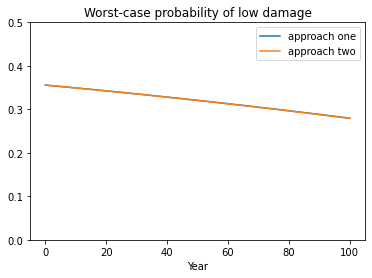

In [27]:
plt.plot(πt[0], label='approach one')
plt.plot(check[0], label='approach two')
plt.ylim(0, 0.5)
plt.title('Worst-case probability of low damage')
plt.legend()
plt.xlabel('Year')
plt.savefig('plot.pdf')

Text(0.5, 0, 'Year')

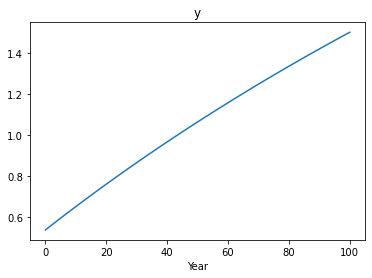

In [10]:
plt.plot(yt)
plt.title('y')
plt.xlabel('Year')